# Working with Git - best practices and example

This notebook provides an overview of developing and deploying ML applications using MLRun and Git. 

Tutorial steps:

1) [Importing MLRun package and creating a new project.](#importing-mlrun)
2) [Configuring Git (user name, user email and create git remote)](#configuring-git)
3) [Developing, logging and registering ML functions and artifacts](#developing) -
    1. [Register a dataset artifact in the project](#register-dataset)
    2. [Train Model func - register this function object into the project, run function](#train-model)
    3. [Register a model artifact into the project](#register-model)
    4. [Serving func - create, add model and register the model serving function](#serving-function)
    5. [Workflow - build, run and register a workflow (workflow includes training the model and deploying)](#workflow)
4) [Pushing project context to Git (end of the day)](#push)
5) [Pulling from Git to the project context (start of the day) and repeat from step 3 (if needed)](#pull)
**Note:** any of the sub-steps in step 3 are optional. Working with Git can also apply on just one of these sub-steps. Also step 2 can come after step 3.

**General:**
Project code, metadata, and configuration are stored and versioned in source control systems like Git or archives (zip, tar) and can be loaded into your work environment or CI system with a single SDK or CLI command.
<br> Before working with Git you need to create a repo and branch (if not master) in Git to be able to push the files to this repo. 
You can work with Git and MLRun with one of the following use-cases:
1. If you have a git repo with files that you want to use and it
    1. Includes the [project.yaml](#project-yaml) - use [project.load](#https://docs.mlrun.org/en/stable/projects/load-project.html) method to load the project from git (it will add the files to the project context)
    2. Doesn't include the [project.yaml](#project-yaml) file you can clone your git repo using the CLI
2. If you have an empty git repo, you can connect your project to git repo using ```git remote add <remote-name> <remote-url>``` in the terminal or ```project.create_remote()``` in MLRun SDK, as shown in this tutorial (step 2)

<a id="importing-mlrun"></a>
## Importing MLRun package and creating a new project.

First thing import the MLRun package

In [1]:
import mlrun

Now create a new project or load it from git remote. The init_git flag is used to initialize git in the context dir.

In [2]:
project = mlrun.new_project(name='new-git-project',init_git=True, overwrite=True)

> 2023-03-15 13:02:56,848 [info] Deleting project new-git-project from MLRun DB due to overwrite
> 2023-03-15 13:03:17,356 [info] Created and saved project new-git-project: {'from_template': None, 'overwrite': True, 'context': './', 'save': True}


<a id="project-yaml"></a>
When you create/save the project it stores the project definitions in the project.yaml. This allows reconstructing the project in a remote cluster or a CI/CD system. A light project YAML looks like (use ```print(project.to_yaml())``` to print) :
```
kind: project
metadata:
  name: new-git-project
spec:
  functions: []
  workflows: []
  artifacts: []
  source: ''
  desired_state: online
```

<a id="configuring-git"></a>
## Configuring Git

1. To add a new remote, use the git remote add command on the terminal, in the directory your repository is stored at:
```
git remote add <remote-name> <remote-url>
```    
The git remote add command takes two arguments:

    1. A unique remote name, for example, “my_awesome_new_remote_repo”
    2. A remote URL, which you can find on the Source sub-tab of your Git repo

Alternatively you can use MLRun SDK command:
````create_remote(url, name='origin', branch=None)```   

Where:
```
    param url:    remote git url
    param name:   name for the remote (default is 'origin')
    param branch: Git branch to use as source (optional)
```
Note that you cannot run this command if there is an existing remote with the same name (run this command only once!)

2. If you are using containerized Jupyter you also need to set your Git parameters, using the following commands in the CLI
```
git config --global user.email "<my@email.com>"
git config --global user.name "<name>"
git config --global credential.helper store
```

<a id="developing"></a>
## Developing and logging ML functions and artifacts

In this section you are going to add functions, workflows and artifacts to [project.yaml](#project-yaml) so that it will contain all project metadata and links to:

1. **artifacts** (artifacts, datasets, models) - set artifact allows the user to load the project with the artifact metadata (it points to the artifact file in a remote storage e.g S3)
2. **functions** - set function to a project allows the user to run the function in a remote cluster, every time the project is loaded
3. **workflows** - set workflow to a project allows the user to run the workflow in a remote cluster, every time the project is loaded


<a id="register-dataset"></a>
### Register a dataset artifact

Register an artifact in the project.yaml, so that it can be further imported on project load

In [3]:
data_url = mlrun.get_sample_path('data/iris/iris.data.raw.csv')
x=project.set_artifact('data', artifact=mlrun.artifacts.DatasetArtifact(),target_path=data_url)  

Save the artifact in MLRun DB (sync artficats metadata from the project.yaml to MLRun db), so that it can be further used as an input for the train model function

In [4]:
project.register_artifacts()
dataset_artifact = project.get_artifact('data') 

In [5]:
print(dataset_artifact.to_yaml())

kind: dataset
metadata:
  key: data
  project: new-git-project
  iter: 0
  tree: 508aee9b427cc0b7025c48c2e6489f5816eb99bd
  tag: latest
  updated: '2023-03-15T13:03:17.455663+00:00'
spec:
  target_path: https://s3.wasabisys.com/iguazio/data/iris/iris.data.raw.csv
  format: ''
  db_key: data
  producer:
    kind: project
    name: new-git-project
    tag: 508aee9b427cc0b7025c48c2e6489f5816eb99bd
  sources: []
  license: ''
status:
  state: created



```{admonition} Note
In case you have a src/fetch_data.py in your context directory that prepares your data, you'll need to first create a serverless function object from src/fetch_data.py, register it in the project.yaml and run:

fetch_data_fn = project.set_function("src/fetch_data.py", name="fetch_data", kind="job", image="mlrun/mlrun", handler="fetch_data")
project.save()
fetch_data_run_remotely = project.run_function("fetch_data",inputs={'dataset':project.get_artifact('data').uri})
```

<a id="train-model"></a>
### Train Model function

Assuming you have a src/trainer.py in your context directory

The other option is to use the auto_trainer function form the hub:
```trainer = project.set_function(func="hub://auto_trainer")```

Create a serverless function object from src/trainer.py, and register it in the project.yaml

In [6]:
trainer = project.set_function(func="src/trainer.py", name="trainer", kind="job", image="mlrun/mlrun", handler="train")

```{admonition} Note

Users who already have their code files in Git repo and want to run the code files only from there can add "with_repo" flag to project.set_function (see example below). In this case, the contents of the Git repo or archive will be available in the current working directory of your MLRun function during runtime. In other words the "with_repo" flag automatically clones the git repo from the project source to your running container and then runs these code files within the container. 
An advantage of this approach is that it allows users to set a relative path to the handler function without the need to handle with file paths in the local directory (e.g folder-name.file-name.function-handler). For example:

project.set_function(name="train", handler="src.trainer.train",  image="mlrun/mlrun", kind="job", with_repo=True)

```

Run the function on the remote cluster (for running locally, add "Local = True" in project.run_function)

In [7]:
trainer_run = project.run_function("trainer",
        inputs={"dataset": dataset_artifact.uri},
        params = {
            "model_class": "sklearn.ensemble.RandomForestClassifier",
            "train_test_split_size": 0.2,
            "label_columns": "label",
            "model_name":'model_iris'}, handler='train')

> 2023-03-15 13:03:17,614 [info] starting run trainer-train uid=366597457e8d403c82a313edaafe7a6e DB=http://mlrun-api:8080
> 2023-03-15 13:03:17,869 [info] Job is running in the background, pod: trainer-train-frvc8
> 2023-03-15 13:03:25,471 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 366597457e8d403c82a313edaafe7a6e -p new-git-project', 'logs_cmd': 'mlrun logs 366597457e8d403c82a313edaafe7a6e -p new-git-project'}
> 2023-03-15 13:03:25,471 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.us-cst-352.iguazio-cd0.com/mlprojects/new-git-project/jobs/monitor/366597457e8d403c82a313edaafe7a6e/overview'}
> 2023-03-15 13:03:25,471 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
new-git-project,...aafe7a6e,0,Mar 15 13:03:21,completed,trainer-train,v3io_user=yevgenykkind=jobowner=yevgenykmlrun/client_version=1.3.0-rc34mlrun/client_python_version=3.7.6host=trainer-train-frvc8,dataset,model_class=sklearn.ensemble.RandomForestClassifiertrain_test_split_size=0.2label_columns=labelmodel_name=model_iris,accuracy=1.0f1_score=1.0precision_score=1.0recall_score=1.0auc-micro=1.0auc-macro=1.0auc-weighted=1.0,feature-importancetest_setconfusion-matrixroc-curvesmodel


> 2023-03-15 13:03:27,224 [info] run executed, status=completed


Results (metrics) and artifacts are generated and tracked automatically by MLRun, to see them, run:
```
trainer_run.artifact('confusion-matrix').show()
trainer_run.outputs
```

<a id="register-model"></a>
### Register a model artifact
Registering a model artifact in the project.yaml allows it to be further imported on project load. You have two options of doing it:

1. When you want to save only the **necessary metadata** for future use (e.g key, kind, tag,  target_path) - set artifact object. We'll use this option in the current tutorial. <br><br>

2. When you want to save **all metadata** (e.g also preview, metrics etc.) of the artifact for future use - set artifact YAML. This can be done with the following commands: 
```
model_obj = project.get_artifact('model_iris')
model_obj.export('model_iris.yaml')
project.set_artifact('model_iris','model.yaml')
```
<br>

In [8]:
target_path = project.get_artifact('model_iris').target_path
project.set_artifact('model', mlrun.artifacts.ModelArtifact(model_file="model_iris.pkl"), target_path=target_path)

<a id="serving-function"></a>
### Real-time serving function (over K8S or Docker). 

Create a model serving function

In [9]:
serving_fn = mlrun.new_function("serving", image="mlrun/mlrun", kind="serving", requirements={})

And add a model to the serving function

In [10]:
serving_fn.add_model('iris_model',model_path=trainer_run.outputs["model"], class_name='mlrun.frameworks.sklearn.SklearnModelServer')

Before registering the serving function in the project (so that it can be further loaded from git) you need to first export
its YAML, so that project YAML will look more compact (otherwise it will include the whole YAML of the serving function)

In [11]:
serving_fn.export('serving.yaml')
project.set_function(func='serving.yaml',name='serving',kind='serving')

> 2023-03-15 13:03:27,286 [info] function spec saved to path: serving.yaml


<a id="workflow"></a>
### Build and run automated ML pipelines and CI/CD

A workflow is created by running an MLRun “workflow”. The workflow describes
a directed acyclic graph (DAG) which is executed using the local, remote, or kubeflow engines. For more details see [running a multi-stage workflow](#https://docs.mlrun.org/en/latest/concepts/workflow-overview.html).

Our workflow (assuming you have a src/workflow.py in your context directory) includes the following steps:
1. Generate/prepare the data (fetch).
2. Train and the model (train).
3. Deploy the model as a real-time serverless function (serving).

The deployment step requires Nuclio to be installed (over K8S or Docker). Use the mlrun deploy_function() method to build and deploy a Nuclio serving function from your serving-function code.

First thing add a multi-stage workflow (./src/workflow.py) to the project with the name 'main' and save the project:

In [12]:
my_workflow = project.set_workflow('main', "./src/workflow.py")

Now run the workflow:

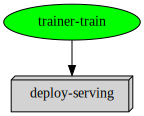

In [ ]:
run_id = project.run(
    workflow_path="./src/workflow.py",
    name = 'main',
    arguments={'dataset_uri':project.get_artifact('data').uri}, 
    watch=True)

Here is how a full project YAML looks now (use ```print(project.to_yaml())``` to print):
```
kind: project
metadata:
  name: new-git-project
spec:
  functions:
  - url: src/trainer.py
    name: trainer
    kind: job
    image: mlrun/mlrun
    handler: train
  - url: serving.yaml
    name: serving
    kind: serving
  workflows:
  - path: ./src/workflow.py
    name: main
  artifacts:
  - kind: dataset
    metadata:
      project: new-git-project
      key: data
    spec:
      target_path: https://s3.wasabisys.com/iguazio/data/iris/iris.data.raw.csv
      format: ''
    status:
      state: created
  - kind: model
    metadata:
      project: new-git-project
      key: model
    spec:
      target_path: s3://mlrun/projects/new-git-project/artifacts/trainer-train/0/model/
      model_file: model_iris.pkl
    status:
      state: created
  source: git://github.com/mlrun/mlrun.git#refs/heads/master
  origin_url: git://github.com/mlrun/mlrun.git#refs/heads/master
  desired_state: online
```

<a id="push"></a>
## Pushing project context to Git

```{admonition} Note
Your very first push you will need to do through the CLI with the following command: git push <origin> <branch>
Github will ask for your username and token. After you provide it and push for the first time, you can do your next pushes through the SDK (and without providing Github username and token) as shown in this tutorial:
```

If your remote has changed (e.g a team is working on the same branch), you need to first pull the latest code from git:

In [ ]:
print(project.to_yaml())
# project.pull("git-mlrun")

```{admonition} Note
For loading the project from a different environment you'll need to set project source. To do this use project.set_source() method:

project.set_source(source="git_remote",pull_at_runtime="True/False",workdir="working_directory_in_git")

Where:
source: valid path to git, zip, or tar file, (or None for current) e.g.
                       git://github.com/mlrun/something.git
                       http://some/url/file.zip
                       
pull_at_runtime: if True (usually during development), allows the user to retrieve the code in runtime, rather than re-build the function image every time the code changes if False (usually in production)

workdir: the relative workdir path (under the context dir), for example: ./mlrun/docs/project/git-mlrun/
```

By default project.push pushes the project.yaml, so there is no need to include it in files_to_add, but you need to include all the other files:

In [ ]:
files_to_add = ['git-mlrun.ipynb','serving.yaml','src/trainer.py','src/workflow.py']

Now you can push your project to Git. The command also saves the project state, commits and pushes the updates to the remote git repo with all the files in files_to_add.

In [ ]:
project.push(branch='main',message='project with a workflow',add=files_to_add)

<a id="pull"></a>
## Pulling from Git to the project context

If your remote has changed (e.g a team is working on the same branch), you need to first pull the latest code from git:

In [ ]:
# project.pull("git-mlrun") 

Congratulations! You've successfully pushed and pulled your poject from git